In [1]:
%matplotlib notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cma

In [2]:
frames = []
ss = ['Confirmed', 'Deaths', 'Recovered']
for s in ss:
    frames.append(pd.read_csv(f'csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-{s}.csv'))

In [3]:
df = pd.concat(frames,axis=0,keys=ss,names=['Status','Idx']).reset_index(level='Idx', drop=True).reset_index(level='Status')

In [4]:
df

,Status,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
0,Confirmed,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,...,43,43,47,48,50,50,50,53,59,70
1,Confirmed,NaN,Japan,36.0000,138.0000,2,1,2,2,4,...,293,331,360,420,461,502,511,581,639,639
2,Confirmed,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,...,110,110,117,130,138,150,150,160,178,178
3,Confirmed,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,...,1,1,1,1,1,1,1,1,1,1
4,Confirmed,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,...,36,50,50,83,93,99,117,129,149,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,Recovered,"Oakland, MI",US,42.5922,-83.3362,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1214,Recovered,"Wayne, MI",US,42.2791,-83.3362,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1215,Recovered,"New Castle, DE",US,39.5393,-75.6674,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1216,Recovered,NaN,Cuba,22.0000,-80.0000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
dfm = df.melt(
    id_vars=['Status','Province/State','Country/Region','Lat','Long'],
    var_name='Date',
    value_name='count'
)
dfm = dfm.rename(columns={'Country/Region':'Country','Province/State':'Province'})
dfm['Date'] = pd.to_datetime(dfm.Date, format='%m/%d/%y')

In [6]:
dfm_country = dfm.groupby(['Country','Status','Date'])['count'].sum().reset_index('Status')
dfm_country.head(2)

Status  count
Country     Date                        
Afghanistan 2020-01-22  Confirmed      0
            2020-01-23  Confirmed      0

In [7]:
dfm_country_piv = dfm_country.pivot(columns='Status').sort_values('Date')
dfm_country_piv.columns = dfm_country_piv.columns.droplevel(level=0)
dfm_country_piv.head(2)

,Status,Confirmed,Deaths,Recovered
Country,Date,,,
Afghanistan,2020-01-22,0,0,0
Netherlands,2020-01-22,0,0,0


<IPython.core.display.Javascript object>


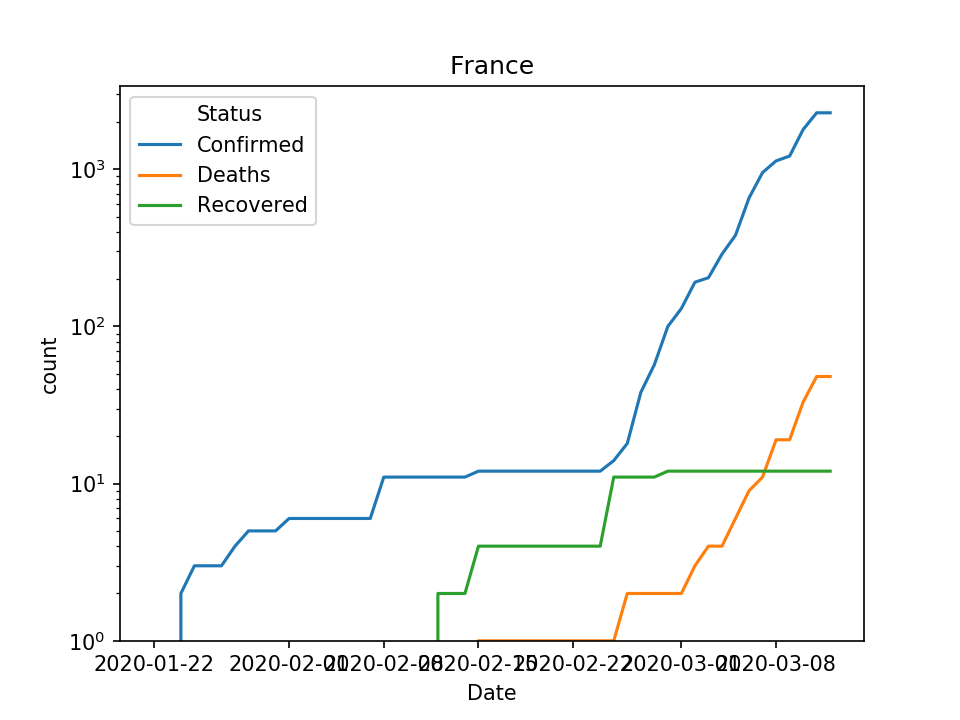

/usr/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


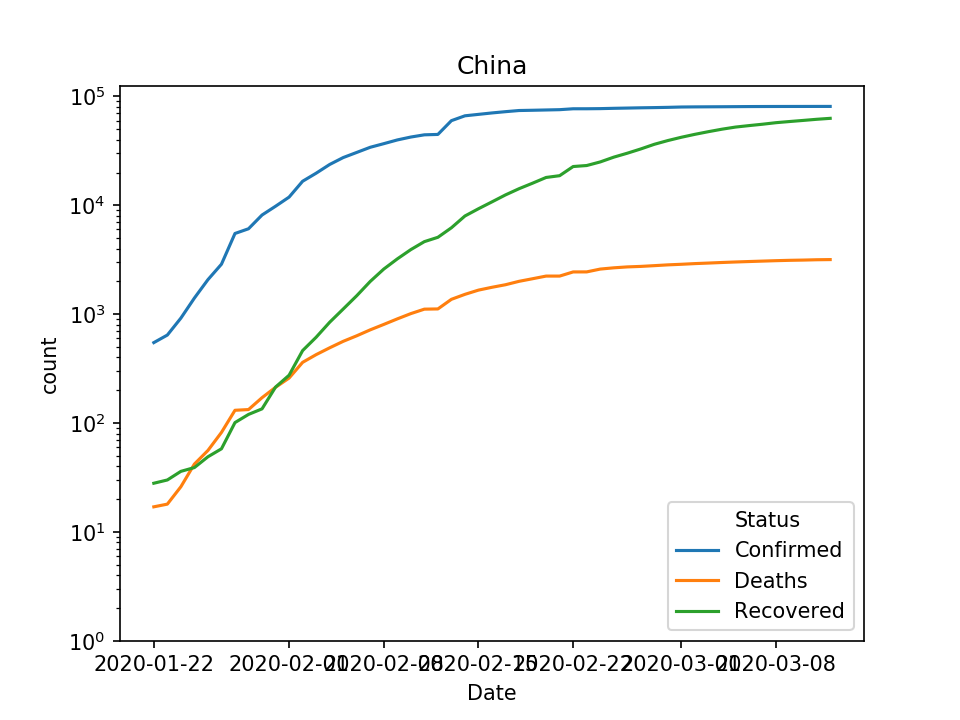

<IPython.core.display.Javascript object>


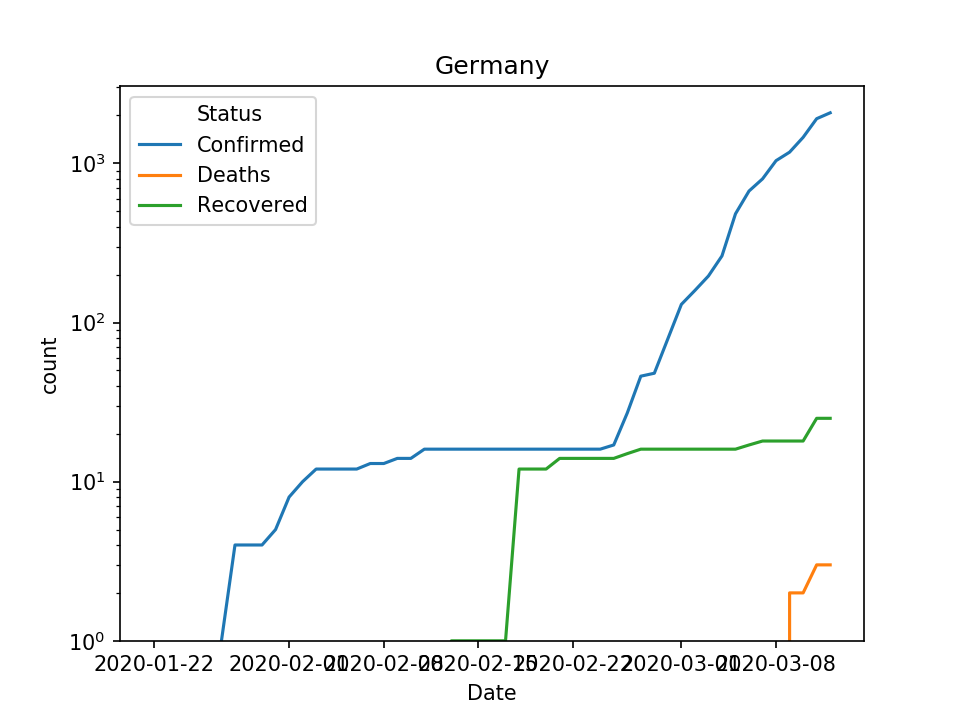

<IPython.core.display.Javascript object>


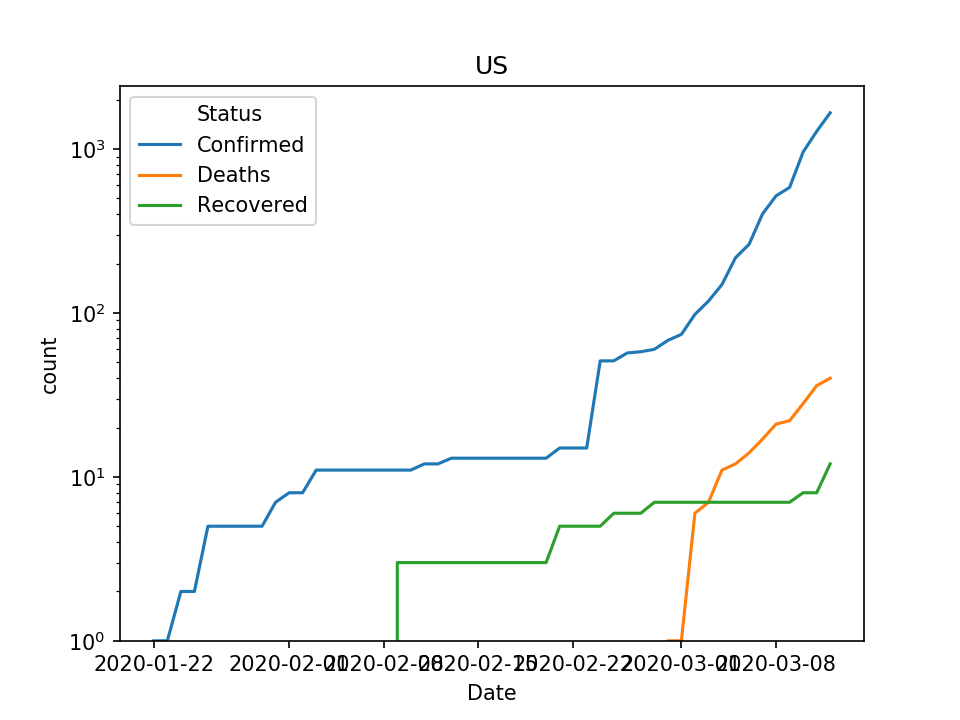

<IPython.core.display.Javascript object>


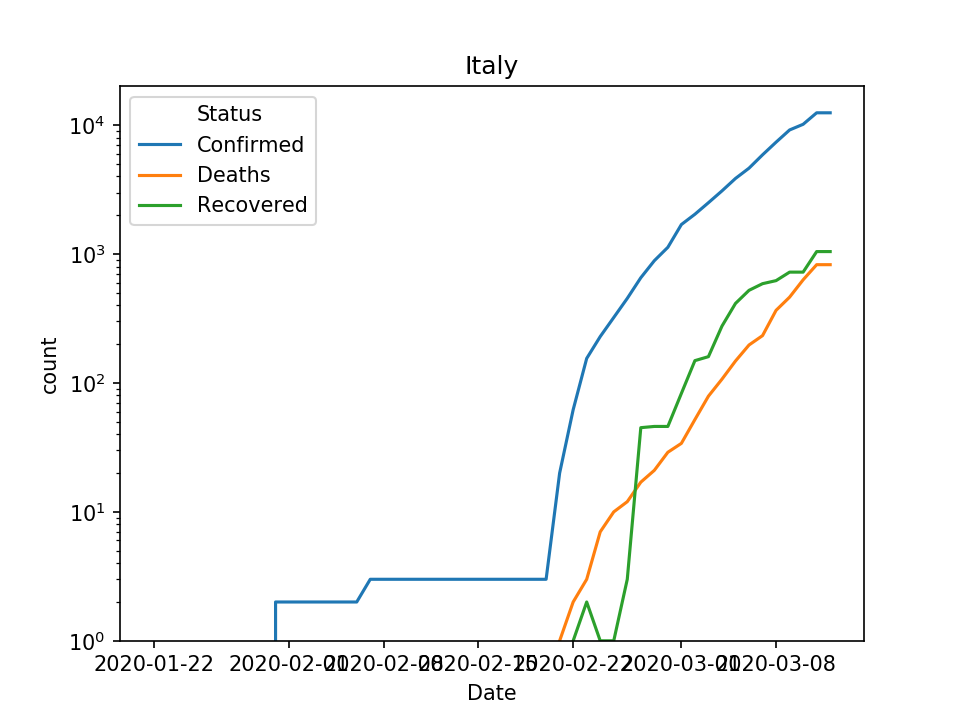

In [8]:
for cntry in ['France', 'China', 'Germany', 'US', 'Italy']:
    plt.figure()
    sns.lineplot(data=dfm_country.reset_index().query(f'Country == "{cntry}"'),x='Date',y='count',hue='Status')
    plt.yscale('log')
    _, ylimh = plt.ylim()
    plt.ylim(1,ylimh)
    plt.title(cntry)

<IPython.core.display.Javascript object>


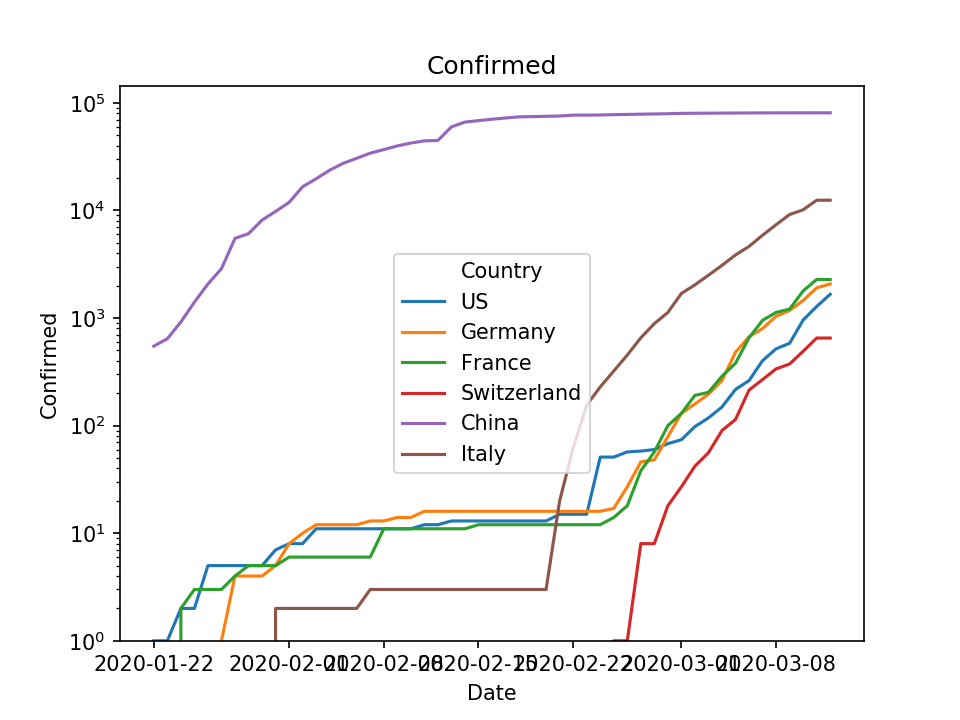

<IPython.core.display.Javascript object>


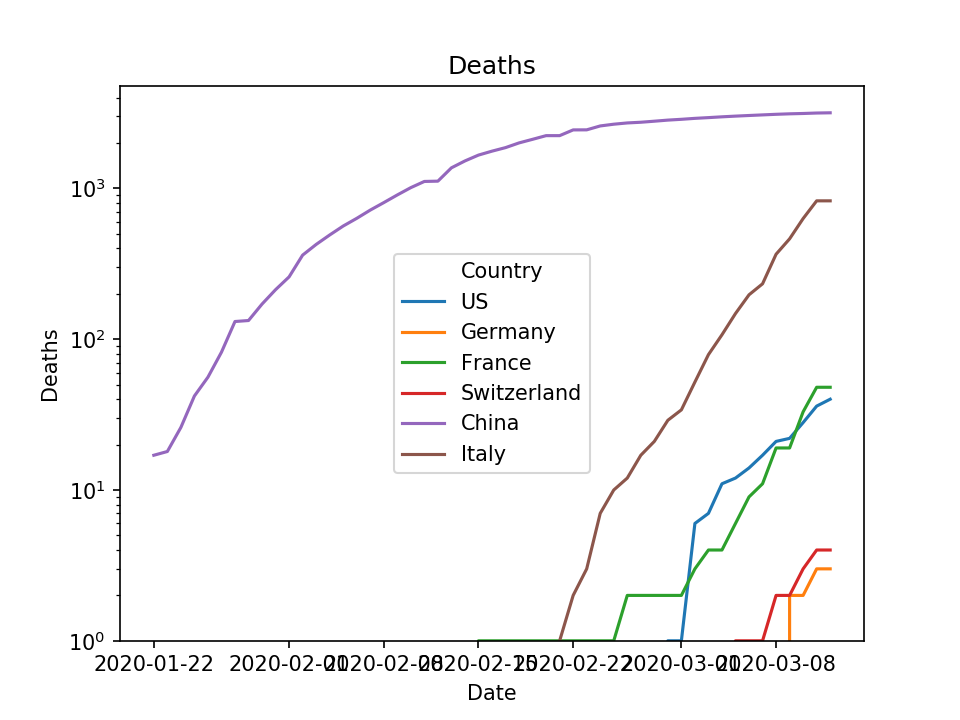

<IPython.core.display.Javascript object>


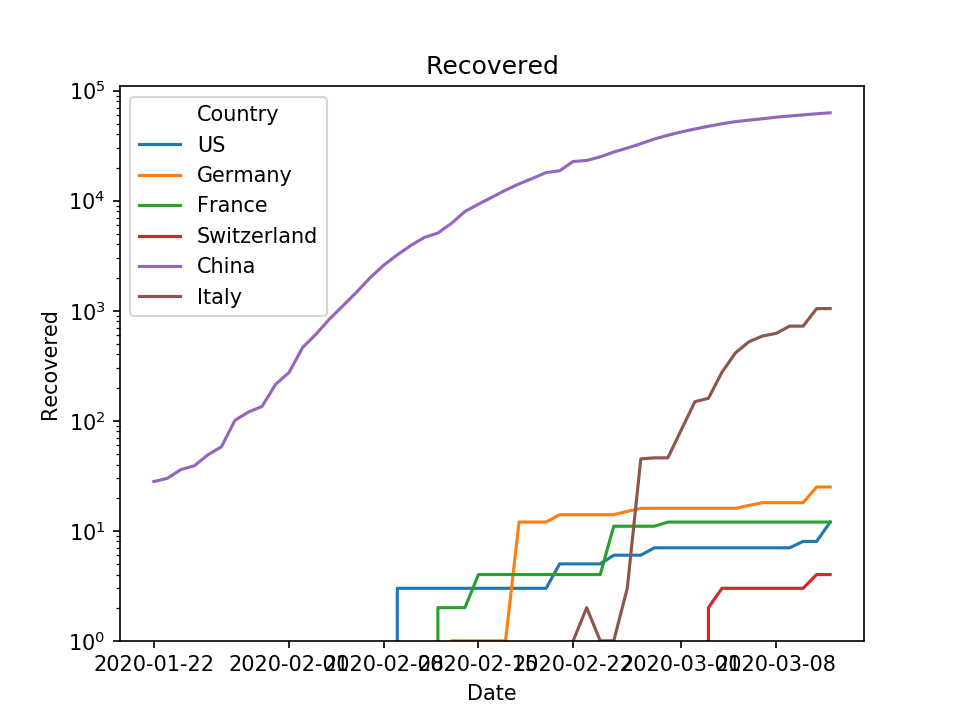

In [9]:
cntries = ['France', 'China', 'Germany', 'US', 'Italy', 'Switzerland']
for status in dfm_country_piv.columns:
    plt.figure()
    sns.lineplot(data=dfm_country_piv.loc[cntries].reset_index(),x='Date',y=status,hue='Country')
    plt.yscale('log')
    _, ylimh = plt.ylim()
    plt.ylim(1,ylimh)
    plt.title(status)

In [10]:
def relative_growth(subdf):
    return subdf.diff() / subdf

In [11]:
relgrowth = dfm_country_piv.groupby(level=0).apply(relative_growth).dropna()

<IPython.core.display.Javascript object>


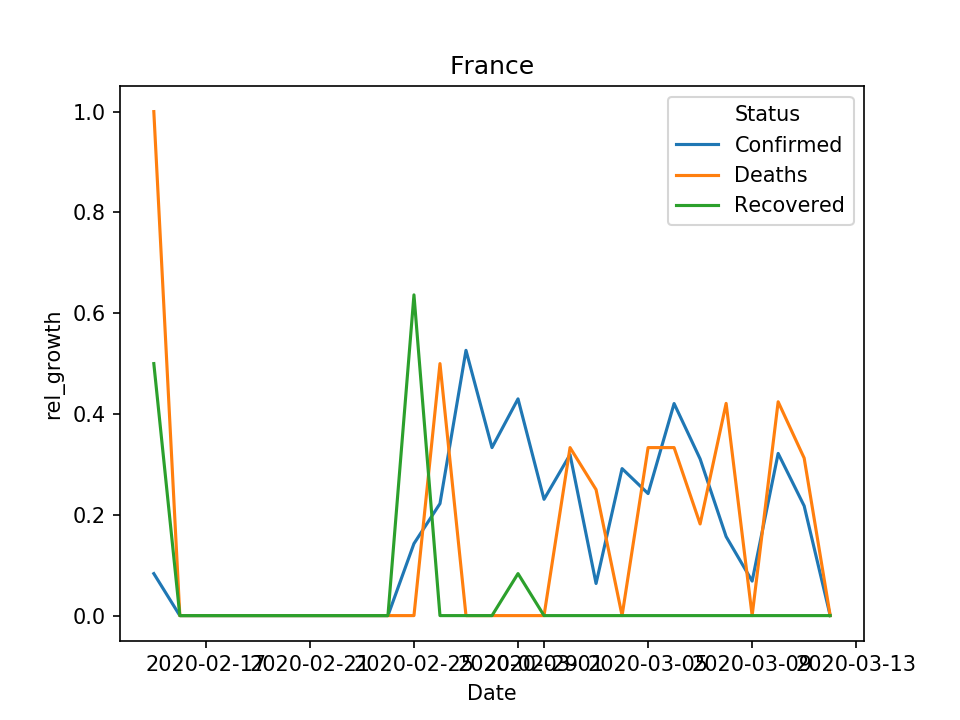

<IPython.core.display.Javascript object>


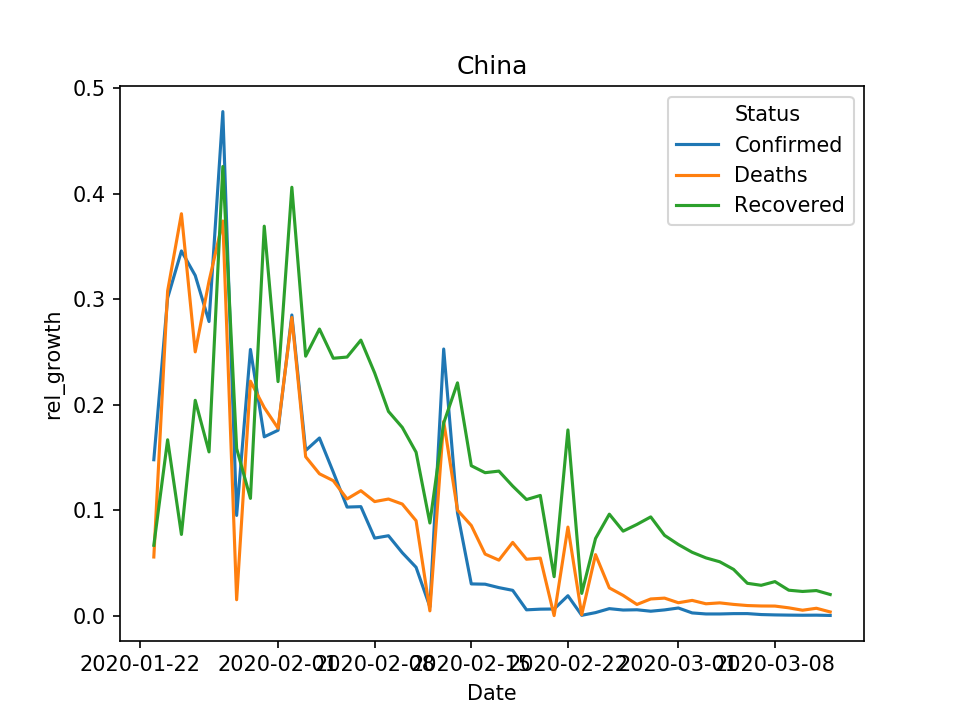

<IPython.core.display.Javascript object>


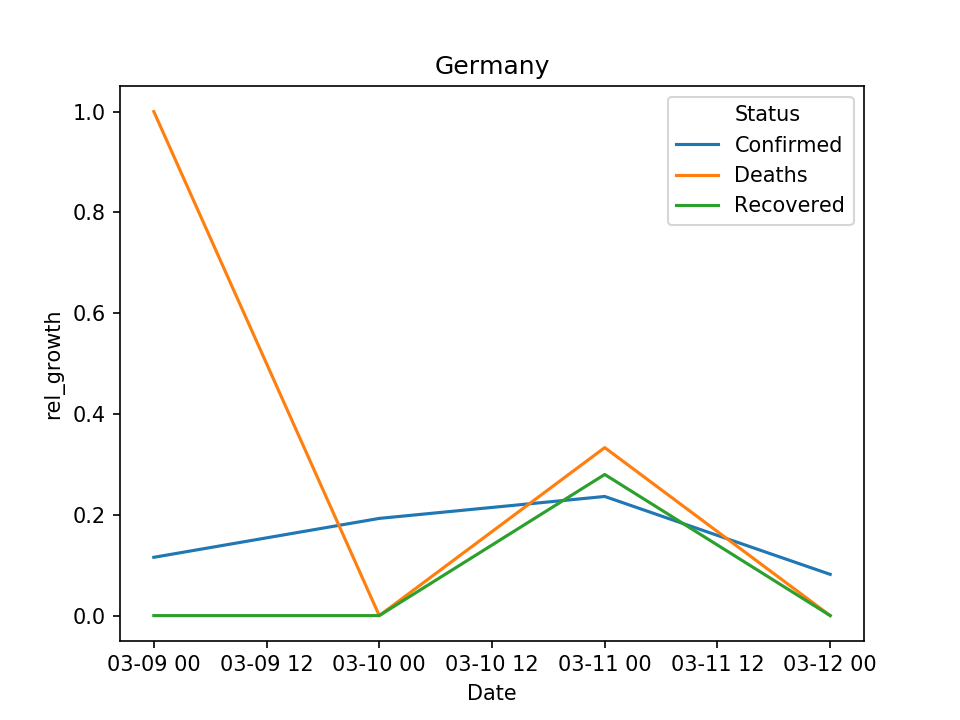

<IPython.core.display.Javascript object>


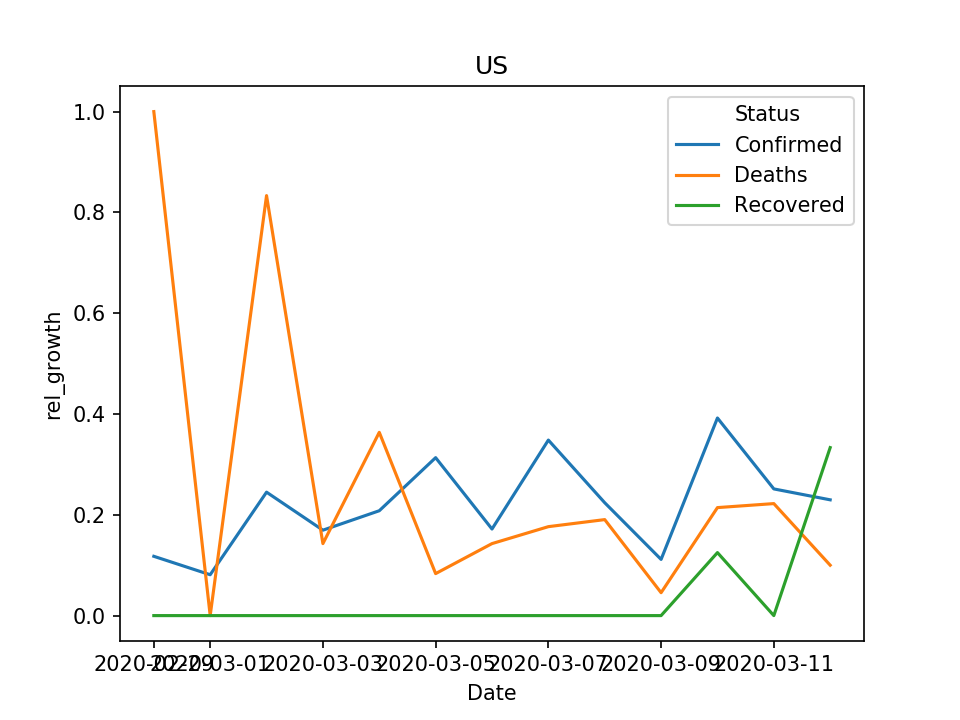

<IPython.core.display.Javascript object>


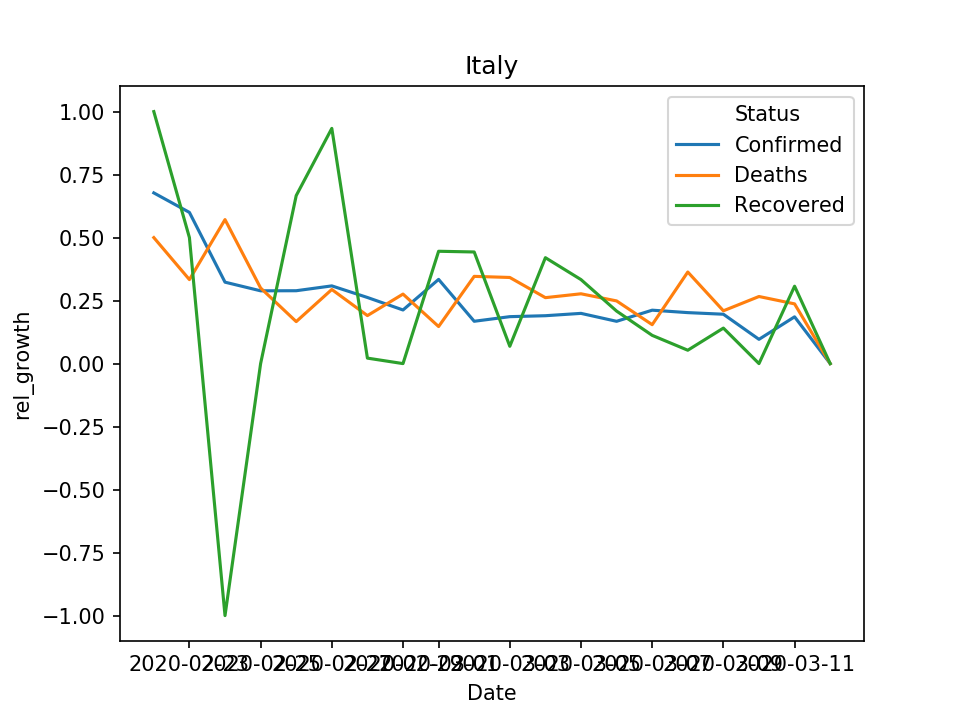

In [12]:
for cntry in ['France', 'China', 'Germany', 'US', 'Italy']:
    plt.figure()
    sns.lineplot(data=relgrowth.loc[cntry].reset_index().melt(id_vars='Date',value_name='rel_growth'),x='Date',y='rel_growth',hue='Status')
    # plt.yscale('log')
    plt.title(cntry)

<IPython.core.display.Javascript object>


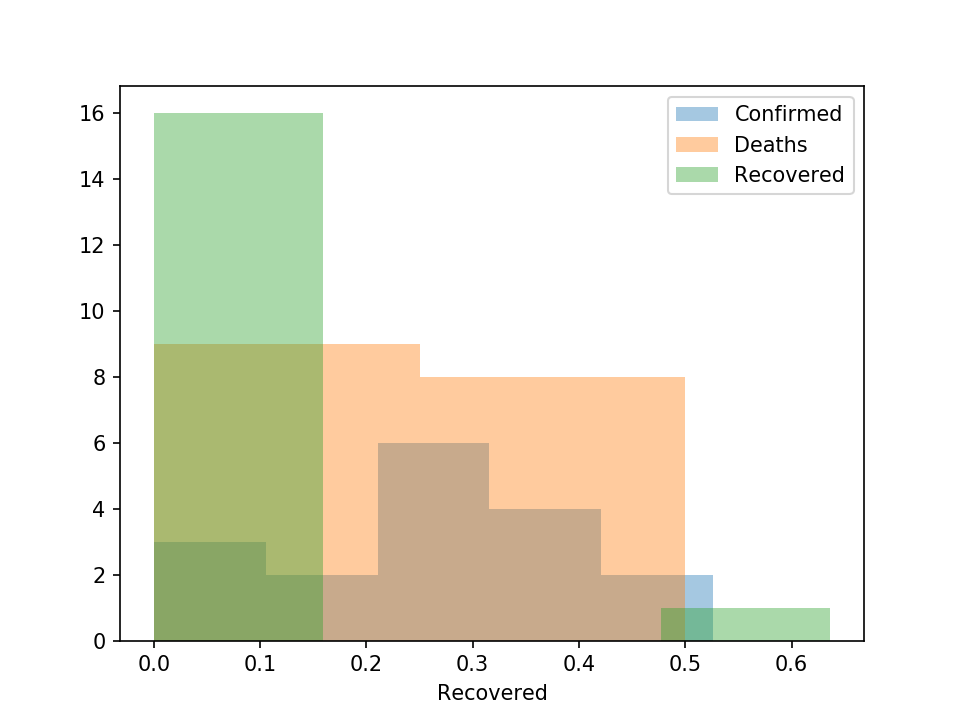

In [15]:
plt.figure()
for status in relgrowth.columns:
    sns.distplot(relgrowth.loc['France'].loc['2020-02-25':][status],label=status,kde=False)
plt.legend()

In [18]:
deathrate = dfm_country_piv['Deaths'] / dfm_country_piv['Confirmed'] 

In [19]:
deathrate.loc['France']

Date
2020-01-22         NaN
2020-01-23         NaN
2020-01-24    0.000000
2020-01-25    0.000000
2020-01-26    0.000000
2020-01-27    0.000000
2020-01-28    0.000000
2020-01-29    0.000000
2020-01-30    0.000000
2020-01-31    0.000000
2020-02-01    0.000000
2020-02-02    0.000000
2020-02-03    0.000000
2020-02-04    0.000000
2020-02-05    0.000000
2020-02-06    0.000000
2020-02-07    0.000000
2020-02-08    0.000000
2020-02-09    0.000000
2020-02-10    0.000000
2020-02-11    0.000000
2020-02-12    0.000000
2020-02-13    0.000000
2020-02-14    0.000000
2020-02-15    0.083333
2020-02-16    0.083333
2020-02-17    0.083333
2020-02-18    0.083333
2020-02-19    0.083333
2020-02-20    0.083333
2020-02-21    0.083333
2020-02-22    0.083333
2020-02-23    0.083333
2020-02-24    0.083333
2020-02-25    0.071429
2020-02-26    0.111111
2020-02-27    0.052632
2020-02-28    0.035088
2020-02-29    0.020000
2020-03-01    0.015385
2020-03-02    0.015707
2020-03-03    0.019608
2020-03-04    0.013889
2020-0

In [26]:
frconf = dfm_country_piv.loc['France'].loc['2020-02-29':'2020-03-11']['Deaths']
def score(x):
    n0, r = x
    simu = n0*np.exp(r*np.arange(frconf.shape[0]))
    return np.sum((simu-frconf.to_numpy())**2)

In [27]:
es = cma.CMAEvolutionStrategy(np.array([14,1/100]),1)
es.optimize(score)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=181259, Fri Mar 13 21:12:45 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      6 4.314358366139331e+03 1.0e+00 8.71e-01  7e-01  9e-01 0:00.0
    2     12 1.853327457338592e+03 1.3e+00 6.88e-01  5e-01  7e-01 0:00.0
    3     18 3.610551098422950e+03 1.6e+00 5.25e-01  3e-01  5e-01 0:00.0
  100    600 3.106369079616170e+01 9.2e+01 5.45e-03  4e-06  4e-05 0:00.2
  135    810 3.106369075396830e+01 4.5e+01 2.88e-05  9e-10  9e-09 0:00.2


<IPython.core.display.Javascript object>


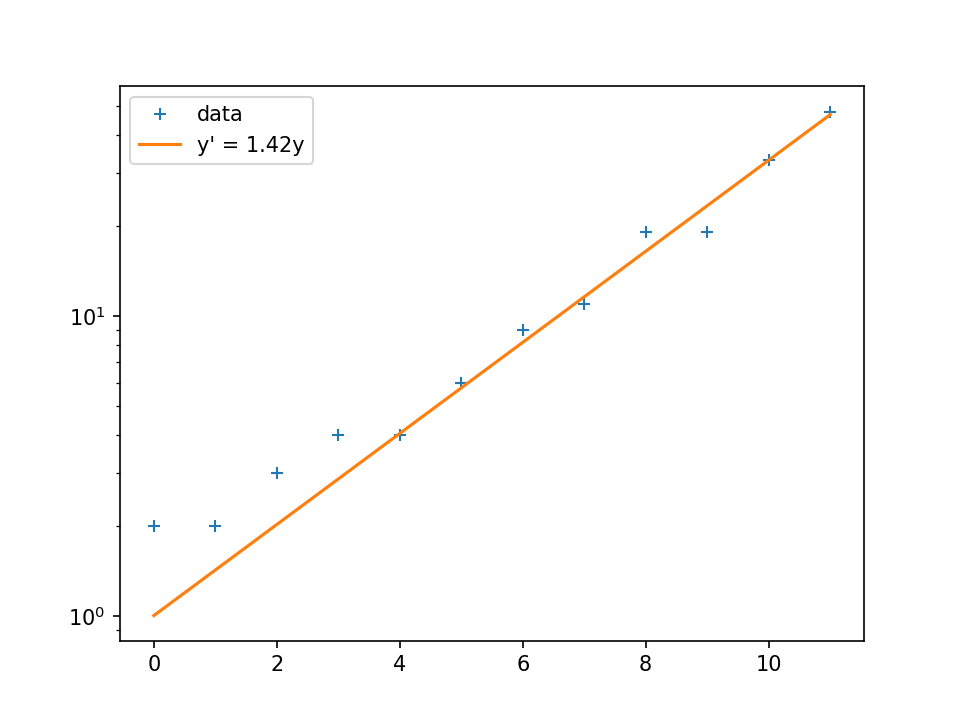

In [28]:
plt.figure()
plt.plot(frconf.to_numpy(),'+',label='data')
plt.plot(es.best.x[0]*np.exp(es.best.x[1]*np.arange(frconf.shape[0])),label=f'y\' = {np.exp(es.best.x[1]):.3}y')
plt.legend()
plt.yscale('log')

In [29]:
np.exp(es.best.x[1])

1.4183257829431892

In [30]:
N = 10
pd.Series(dfm_country_piv.loc['France'].loc['2020-03-11']['Confirmed']*np.exp(es.best.x[1]*np.arange(N)),
          index=pd.date_range(start='2020-03-11',periods=N))

2020-03-11     2284.000000
2020-03-12     3239.456088
2020-03-13     4594.604093
2020-03-14     6516.645447
2020-03-15     9242.726256
2020-03-16    13109.196953
2020-03-17    18593.112033
2020-03-18    26371.090181
2020-03-19    37402.797128
2020-03-20    53049.351521
Freq: D, dtype: float64

In [69]:
np.log(2)/es.best.x[1]

2.5738587565052016

<IPython.core.display.Javascript object>


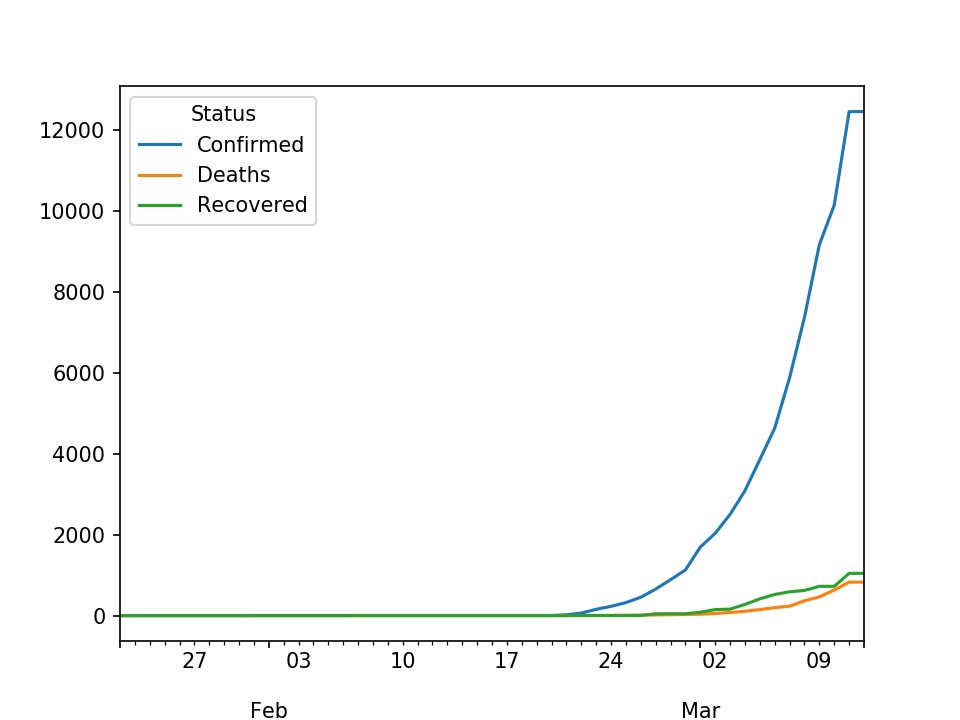

In [34]:
dfm_country_piv.loc['Italy'].plot()

In [38]:
relgrowth.loc['Italy']

Status,Confirmed,Deaths,Recovered
Date,,,
2020-02-22,0.677419,0.500000,1.000000
2020-02-23,0.600000,0.333333,0.500000
2020-02-24,0.323144,0.571429,-1.000000
2020-02-25,0.288820,0.300000,0.000000
2020-02-26,0.289183,0.166667,0.666667
2020-02-27,0.308397,0.294118,0.933333
2020-02-28,0.262387,0.190476,0.021739
2020-02-29,0.212766,0.275862,0.000000
2020-03-01,0.334120,0.147059,0.445783
